In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"abdulrahmanh524","key":"4e36e7c7e200076895632ff4f42b4284"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d kwentar/blur-dataset
!unzip -q blur-dataset.zip -d /content/blur-dataset

Dataset URL: https://www.kaggle.com/datasets/kwentar/blur-dataset
License(s): CC0-1.0
blur-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [7]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf

dataset_path = '/content/blur-dataset'
IN = os.path.join(dataset_path, 'defocused_blurred')
OUT = os.path.join(dataset_path, 'sharp')

def data_load(path):
    result = []
    for file in tqdm(sorted(os.listdir(path))):
        if any(extension in file for extension in ['.jpg', 'jpeg', '.png']):
            image = tf.keras.preprocessing.image.load_img(os.path.join(path, file), target_size=(224, 224))
            image = tf.keras.preprocessing.image.img_to_array(image).astype('float32') / 255
            result.append(image)
    return np.array(result)

input_images = data_load(IN)
output_images = data_load(OUT)


100%|██████████| 350/350 [00:06<00:00, 50.52it/s]


In [8]:
from sklearn.model_selection import train_test_split

# Split the preprocessed data into training and validation sets
x_train, x_test, y_train, y_test= train_test_split(input_images, output_images, test_size=0.1, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((246, 224, 224, 3), (28, 224, 224, 3), (246, 224, 224, 3), (28, 224, 224, 3))

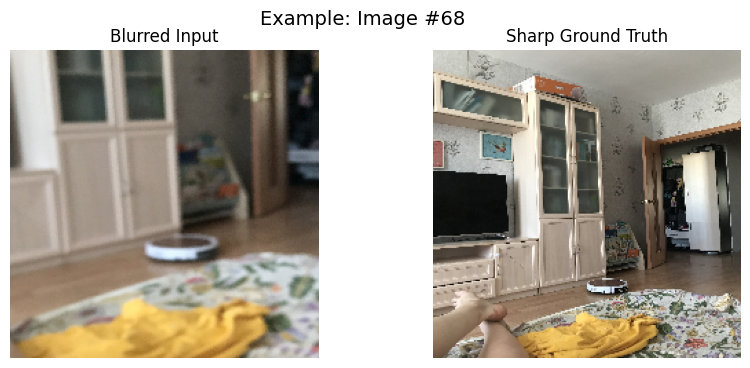

In [9]:
import random
import matplotlib.pyplot as plt

r = random.randint(0, len(input_images) - 1)

fig = plt.figure(figsize=(10, 4))
plt.suptitle(f'Example: Image #{r}', fontsize=14)

# Blurred image
ax = fig.add_subplot(1, 2, 1)
ax.imshow(input_images[r])
ax.set_title("Blurred Input")
ax.axis("off")

# Sharp image
ax = fig.add_subplot(1, 2, 2)
ax.imshow(output_images[r])
ax.set_title("Sharp Ground Truth")
ax.axis("off")

plt.show()


In [10]:
# Network Parameters
input_shape = (224, 224, 3)
batch_size = 32

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, LeakyReLU

model = Sequential([
    Input(shape=input_shape),

    Conv2D(64, (3, 3), padding='same'),
    LeakyReLU(),

    Conv2D(128, (3, 3), padding='same'),
    LeakyReLU(),

    Conv2D(256, (3, 3), padding='same'),
    LeakyReLU(),

    Conv2DTranspose(256, (3, 3), padding='same'),
    LeakyReLU(),

    Conv2DTranspose(128, (3, 3), padding='same'),
    LeakyReLU(),

    Conv2DTranspose(64, (3, 3), padding='same'),
    LeakyReLU(),

    Conv2DTranspose(32, (3, 3), padding='same'),
    LeakyReLU(),

    Conv2DTranspose(3, (3, 3), padding='same', activation='sigmoid'),
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 224, 224, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 224, 224, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 224, 224, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose                │ (None, 224, 224, 256)  │       590,080 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 224, 224, 256)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_1              │ (None, 224, 224, 128)  │       295,040 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 224, 224, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 224, 224, 64)   │        73,792 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 224, 224, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 224, 224, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 224, 224, 3)    │           867 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,349,059 (5.15 MB)

 Trainable params: 1,349,059 (5.15 MB)

 Non-trainable params: 0 (0.00 B)

In [16]:
import tensorflow as tf
from keras import backend as K

# Structural Similarity Index (1 - SSIM = loss)
def SSIMLoss(y_true, y_pred):
    return 1 - tf.reduce_mean(tf.image.ssim(y_true, y_pred, max_val=1.0))

# Peak Signal-to-Noise Ratio
def PSNR(y_true, y_pred):
    max_pixel = 1.0
    mse = tf.reduce_mean(tf.square(y_pred - y_true), axis=[1, 2, 3])
    psnr = 10.0 * tf.math.log((max_pixel ** 2) / mse) / tf.math.log(10.0)
    return tf.reduce_mean(psnr)

In [17]:
from keras.callbacks import ReduceLROnPlateau

model.compile(
    loss='mse',
    optimizer='adam',
    metrics=[SSIMLoss, PSNR]
)

lr_reducer = ReduceLROnPlateau(
    factor=np.sqrt(0.1),
    cooldown=0,
    patience=5,
    verbose=1
)

callbacks = [lr_reducer]

history = model.fit(
    x_train,
    y_train,
    validation_split=0.2,
    epochs=70,
    batch_size=batch_size,
    callbacks=callbacks
)

history.history.keys()


Epoch 1/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 200s 13s/step - loss: 0.0724 - psnr: 11.8936 - ssim_loss: 0.6630 - val_loss: 0.0632 - val_psnr: 12.3867 - val_ssim_loss: 0.6291 - learning_rate: 0.0010
Epoch 2/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 19s 2s/step - loss: 0.0611 - psnr: 12.6526 - ssim_loss: 0.6571 - val_loss: 0.0463 - val_psnr: 13.7286 - val_ssim_loss: 0.6213 - learning_rate: 0.0010
Epoch 3/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.0441 - psnr: 14.0989 - ssim_loss: 0.6346 - val_loss: 0.0578 - val_psnr: 12.7078 - val_ssim_loss: 0.6200 - learning_rate: 0.0010
Epoch 4/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.0490 - psnr: 13.7084 - ssim_loss: 0.6427 - val_loss: 0.0433 - val_psnr: 13.9724 - val_ssim_loss: 0.6045 - learning_rate: 0.0010
Epoch 5/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - loss: 0.0433 - psnr: 14.2253 - ssim_loss: 0.6348 - val_loss: 0.0407 - val_psnr: 14.3278 - val_ssim_loss: 0.6044 - learning_rate: 0.0010
Epoch 6/70
7/7 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - loss: 0.0406 - psn

dict_keys(['loss', 'psnr', 'ssim_loss', 'val_loss', 'val_psnr', 'val_ssim_loss', 'learning_rate'])


       Input                        Ground Truth                  Predicted Output


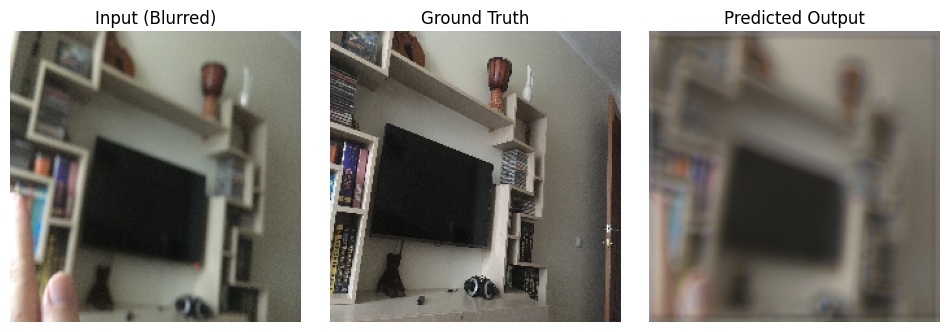

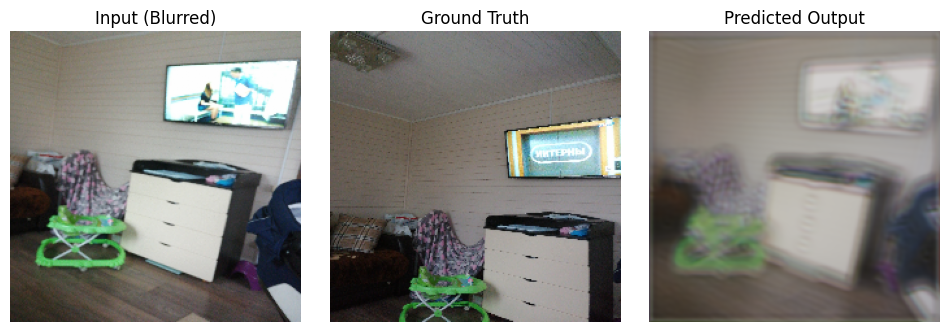

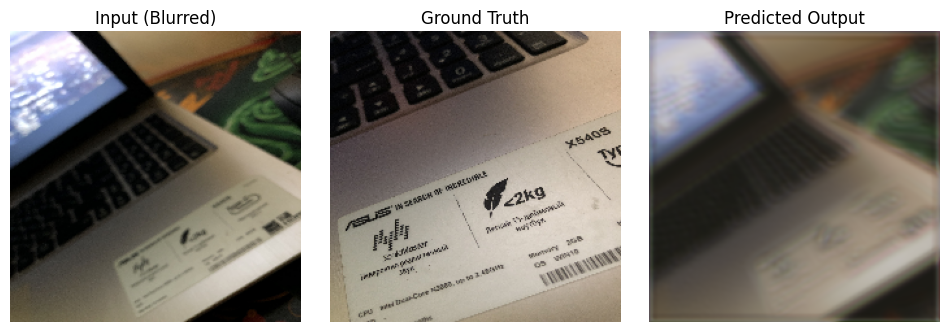

In [18]:
import random
import matplotlib.pyplot as plt

print("\n       Input                        Ground Truth                  Predicted Output")
for i in range(3):
    r = random.randint(0, len(x_test) - 1)

    x = x_test[r]
    y = y_test[r]
    x_inp = x.reshape(1, 224, 224, 3)

    result = model.predict(x_inp, verbose=0)[0]
    fig = plt.figure(figsize=(12, 6))
    fig.subplots_adjust(hspace=0.1, wspace=0.1)

    ax = fig.add_subplot(1, 3, 1)
    ax.imshow(x)
    ax.set_title("Input (Blurred)")
    ax.axis('off')

    ax = fig.add_subplot(1, 3, 2)
    ax.imshow(y)
    ax.set_title("Ground Truth")
    ax.axis('off')

    ax = fig.add_subplot(1, 3, 3)
    ax.imshow(result)
    ax.set_title("Predicted Output")
    ax.axis('off')

    plt.show()


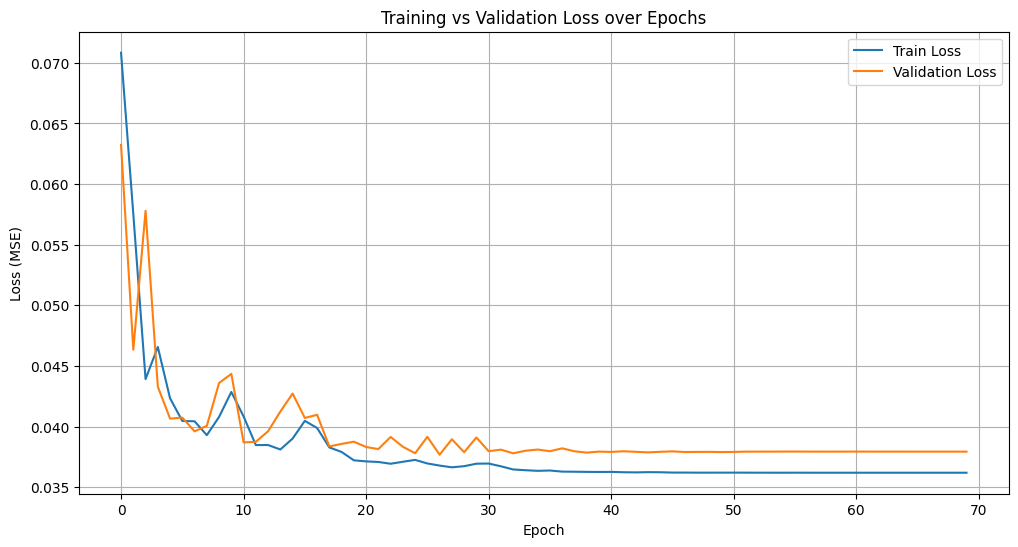

In [22]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training vs Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.grid(True)
plt.legend()
plt.show()

In [23]:
if 'SSIMLoss' in history.history:
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['SSIMLoss'], label='Train SSIM Loss')
    plt.title('SSIM Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('1 - SSIM')
    plt.grid(True)
    plt.legend()
    plt.show()

if 'PSNR' in history.history:
    plt.figure(figsize=(12, 5))
    plt.plot(history.history['PSNR'], label='Train PSNR')
    plt.title('PSNR over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('PSNR (dB)')
    plt.grid(True)
    plt.legend()
    plt.show()


In [27]:
!pip install scikit-image

📊 Average PSNR: 14.40 dB
📊 Average SSIM: 0.3672


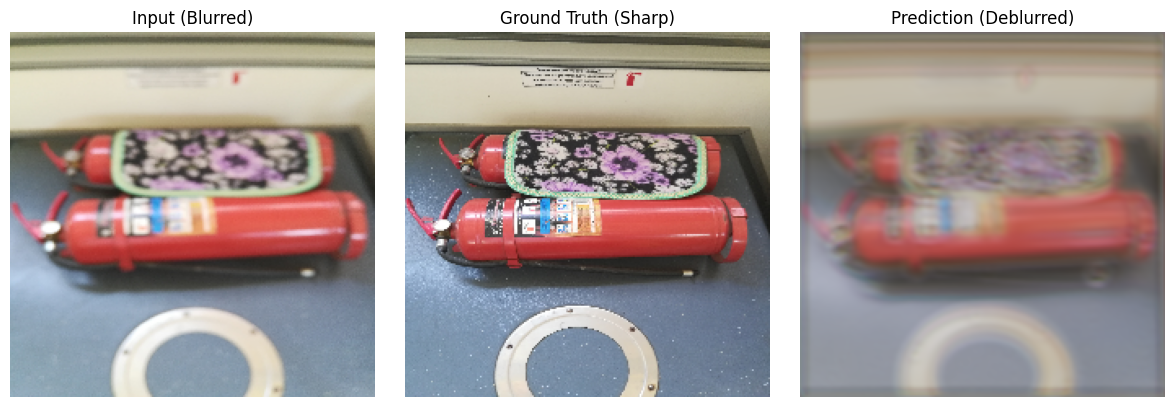

In [29]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as compare_ssim

psnr_scores = []
ssim_scores = []

for i in range(len(x_test)):
    inp = x_test[i].reshape(1, 224, 224, 3)
    pred = model.predict(inp, verbose=0)[0]
    true = y_test[i]

    # PSNR
    psnr_val = tf.image.psnr(true, pred, max_val=1.0).numpy()
    psnr_scores.append(psnr_val)

    # SSIM
    ssim_val = compare_ssim(true, pred, channel_axis=2, data_range=1.0)
    ssim_scores.append(ssim_val)

avg_psnr = np.mean(psnr_scores)
avg_ssim = np.mean(ssim_scores)

print(f"📊 Average PSNR: {avg_psnr:.2f} dB")
print(f"📊 Average SSIM: {avg_ssim:.4f}")

import random
r = random.randint(0, len(x_test) - 1)
example_input = x_test[r]
example_gt = y_test[r]
example_pred = model.predict(example_input.reshape(1, 224, 224, 3), verbose=0)[0]

plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.imshow(example_input)
plt.title("Input (Blurred)")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(example_gt)
plt.title("Ground Truth (Sharp)")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(example_pred)
plt.title("Prediction (Deblurred)")
plt.axis('off')

plt.tight_layout()
plt.show()
